<a href="https://colab.research.google.com/github/CeciASanz/NLP/blob/main/Ejercicio%205/5%20-%20clothing_ecommerce_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Sentiment analysis con Embeddings + LSTM

### Objetivo
El objetivo es utilizar las críticas de compradores de ropa para que el sistema determine la evaluación del comprador y su crítica (cuantas estrellas le asigna al producto).

In [2]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [3]:
import numpy as np
import random
import io
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.utils.np_utils import to_categorical
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

### Datos
Utilizaremos como dataset críticas de compradores de ropa (eCommerce) los cuales puntuaron a cada prenda con un puntaje de 1 a 5 estrellas.\
Referencia del dataset: [LINK](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews/version/1)

In [4]:
# Descargar la carpeta de dataset
import os
import platform
if platform.system() == 'Windows':
    !curl https://raw.githubusercontent.com/CeciASanz/NLP/main/Ejercicio%205/clothing_ecommerce_reviews.csv
else:
    !wget clothing_ecommerce_reviews.csv https://raw.githubusercontent.com/CeciASanz/NLP/main/Ejercicio%205/clothing_ecommerce_reviews.csv

--2023-08-29 00:09:28--  http://clothing_ecommerce_reviews.csv/
Resolving clothing_ecommerce_reviews.csv (clothing_ecommerce_reviews.csv)... failed: Name or service not known.
wget: unable to resolve host address ‘clothing_ecommerce_reviews.csv’
--2023-08-29 00:09:28--  https://raw.githubusercontent.com/CeciASanz/NLP/main/Ejercicio%205/clothing_ecommerce_reviews.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8480236 (8.1M) [text/plain]
Saving to: ‘clothing_ecommerce_reviews.csv’

clothing_ecommerce_ 100%[===================>]   8.09M  --.-KB/s    in 0.06s   

2023-08-29 00:09:29 (145 MB/s) - ‘clothing_ecommerce_reviews.csv’ saved [8480236/8480236]

FINISHED --2023-08-29 00:09:29--
Total wall clock time: 0.7s
Downloaded: 1 files, 8.1M in 0.06s (145 MB/s)

In [5]:
# Armar el dataset
df = pd.read_csv('clothing_ecommerce_reviews.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


### 1 - Limpieza de datos
Alumno:
- Del dataset unicamente utilizar las columnas "Review Text" y "Rating.
- Tranformar el rating 1-5 a una escala numérica de 0 a 4.



In [6]:
df_reviews = df.loc[:, ['Review Text', 'Rating']].dropna()
df_reviews['Rating'] = df_reviews['Rating'] - 1
df_reviews.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,3
1,Love this dress! it's sooo pretty. i happene...,4
2,I had such high hopes for this dress and reall...,2
3,"I love, love, love this jumpsuit. it's fun, fl...",4
4,This shirt is very flattering to all due to th...,4


In [6]:
# Alumno: Observar como está distribuido el dataset respecto a la columna Rating
# es decir, observar que tan balanceado se encuentra respecot a cada clase

In [7]:
df_reviews['Rating'].value_counts()

4    12540
3     4908
2     2823
1     1549
0      821
Name: Rating, dtype: int64

In [ ]:
#Agrupo las columnas 0 y 1, las columnas 2 y 3 y reasigno los valores

In [8]:
mapping = {0: 0, 1: 0, 2: 1, 3: 1, 4: 2}
df_reviews['Rating'] = df_reviews['Rating'].replace(mapping)

In [9]:
df_reviews['Rating'].value_counts()

2    12540
1     7731
0     2370
Name: Rating, dtype: int64

In [19]:
# Alumno: tomar la columna de las review y almacenarlo todo en un vector numpy de reviews

In [10]:
text_sequences = df_reviews['Review Text'].values

In [21]:
# Alumno: Cuantas reviews (rows) hay para evaluar?

In [11]:
text_sequences.shape

(22641,)

In [ ]:
# Alumno: Concatenar todas las reviews para armar el corpus

In [12]:
corpus = ' '.join(text_sequences)

In [ ]:
# Alumno: ¿Cuál es la longitud de ese corpus?

In [13]:
len(corpus)

7008431

In [14]:
# Alumno: Utilizar "text_to_word_sequence" para separar las palabras en tokens
# recordar que text_to_word_sequence automaticamente quita los signos de puntuacion y pasa el texto a lowercase
from keras.preprocessing.text import text_to_word_sequence
tokens = text_to_word_sequence(corpus)

In [ ]:
# Alumno: Dar un vistazo a los primeros 20 tokens/palabras

In [15]:
tokens[:20]

['absolutely',
 'wonderful',
 'silky',
 'and',
 'sexy',
 'and',
 'comfortable',
 'love',
 'this',
 'dress',
 "it's",
 'sooo',
 'pretty',
 'i',
 'happened',
 'to',
 'find',
 'it',
 'in',
 'a']

In [ ]:
# Alumno: ¿Cuántos tokens/palabras hay?

In [16]:
len(tokens)

1369118

In [17]:
# Alumno: Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# num_words --> the maximum number of words to keep, based on word frequency.
# Only the most common num_words-1 words will be kept.
from keras.preprocessing.text import Tokenizer
num_words = 2000
vocab_size = num_words
tok = Tokenizer(num_words=2000)
tok.fit_on_texts(tokens)

In [29]:
# Alumno: Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario

In [18]:
word_index = tok.word_index
print(f'tamaño de vocabulario : {len(word_index)}')

tamaño de vocabulario : 14740


In [ ]:
# Alumno: Convertir las palabras/tokens a números

In [19]:
sequences = tok.texts_to_sequences(text_sequences)

In [ ]:
# Alumno: Determinar cual es la oración más larga

In [20]:
seqs_lenght = [len(s) for s in sequences]
print(f'el máximo es {max(seqs_lenght)}')

el máximo es 115


(array([ 21.,  15.,  26.,  22.,  39.,  54.,  78., 292., 148., 133., 189.,
        168., 201., 185., 183., 385., 207., 230., 222., 228., 238., 230.,
        259., 499., 249., 267., 251., 283., 236., 259., 503., 259., 287.,
        269., 291., 298., 258., 242., 499., 266., 248., 229., 270., 232.,
        227., 246., 506., 254., 226., 226., 241., 236., 235., 455., 215.,
        221., 227., 219., 197., 201., 191., 404., 170., 204., 193., 179.,
        185., 189., 175., 431., 214., 219., 245., 216., 277., 288., 606.,
        336., 337., 367., 366., 383., 349., 315., 624., 229., 234., 180.,
        131., 105.,  62.,  49.,  64.,  21.,   6.,   9.,   2.,   4.,   1.,
          1.]),
 array([  2.  ,   3.13,   4.26,   5.39,   6.52,   7.65,   8.78,   9.91,
         11.04,  12.17,  13.3 ,  14.43,  15.56,  16.69,  17.82,  18.95,
         20.08,  21.21,  22.34,  23.47,  24.6 ,  25.73,  26.86,  27.99,
         29.12,  30.25,  31.38,  32.51,  33.64,  34.77,  35.9 ,  37.03,
         38.16,  39.29,  40.42

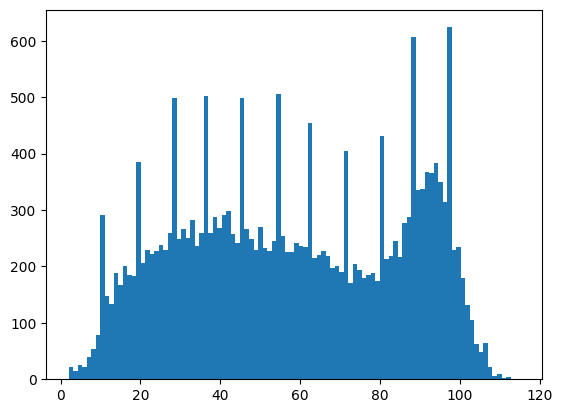

In [21]:
plt.figure()
plt.hist(seqs_lenght,bins=100)

In [22]:
# Alumno: Realizar padding de las sentencias al mismo tamaño
# tomando de referencia la máxima sentencia
from tensorflow.keras.utils import pad_sequences
maxlen = 115
X = pad_sequences(sequences, padding='pre', maxlen=maxlen)

In [23]:
# Alumno: Observar las dimensiones de la variable input
X.shape

(22641, 115)

In [ ]:
# Alumno tomar la columna rating y alcemacenarla en una variable "y" transformada a oneHotEncoding
# Su shape debe ser equivalente la cantidad de rows del corpus y a la cantidad
# de clases que se deseen predecir (en este ejemplo son 5)

In [24]:
y = to_categorical(df_reviews['Rating'])
y.shape

(22641, 3)

In [25]:
# Alumno: Dividir los datos en train y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
#Realizo un oversabling para balacear las clases
from imblearn.over_sampling import RandomOverSampler

oversampler=RandomOverSampler();
X_train_os,y_train_os=oversampler.fit_resample(X_train,y_train);

In [30]:
pd.DataFrame(y_train_os).value_counts()

0  1  2
0  0  1    9995
   1  0    9995
1  0  0    9995
dtype: int64

In [ ]:
# Alumno: determinar la dimensiones de entrada y salida

In [32]:
in_shape = X_train_os.shape[1] # max input sentence len
out_shape = 3 # multiclass classification
print("in_shape", in_shape, ", out_shape", out_shape)

in_shape 115 , out_shape 3


### 2 - Entrenar el modelo con Embeddings + LSTM

In [33]:
# Alumno: Entrene su modelo con LSTM entrenando sus propios embeddings
# o utilizando embeddings pre-entrenados.
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import Bidirectional
from tensorflow.keras import backend as K

In [34]:
def custom_f1_score(y_true, y_pred):
    # Define the true positives, false positives and false negatives
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    fp = K.sum(K.round(K.clip(y_pred - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))

    # Calculate the precision and recall
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())

    # Calculate the F1 score
    f1_score = 2 * ((precision * recall) / (precision + recall + K.epsilon()))

    return f1_score

In [35]:
model = Sequential()
# input_dim = vocab_size (max n_words)
# input_length = setencias con padding a 200
# output_dim = 50 --> crear embeddings de tamaño 50
model.add(Embedding(input_dim=vocab_size+1, output_dim=10, input_length=in_shape))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64)) # La última capa LSTM no lleva return_sequences

model.add(Dense(units=128, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=out_shape, activation='softmax'))

model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=[custom_f1_score])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 115, 10)           20010     
                                                                 
 lstm (LSTM)                 (None, 115, 64)           19200     
                                                                 
 dropout (Dropout)           (None, 115, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 3

In [36]:

hist = model.fit(X_train_os, y_train_os, epochs=10, validation_split=0.2)

Epoch 1/10
750/750 [==============================] - 131s 164ms/step - loss: 0.7458 - custom_f1_score: 0.6026 - val_loss: 0.8990 - val_custom_f1_score: 0.3484
Epoch 2/10
750/750 [==============================] - 120s 160ms/step - loss: 0.6158 - custom_f1_score: 0.7188 - val_loss: 0.8470 - val_custom_f1_score: 0.4557
Epoch 3/10
750/750 [==============================] - 121s 162ms/step - loss: 0.5721 - custom_f1_score: 0.7455 - val_loss: 0.7790 - val_custom_f1_score: 0.5838
Epoch 4/10
750/750 [==============================] - 121s 161ms/step - loss: 0.5135 - custom_f1_score: 0.7791 - val_loss: 0.7031 - val_custom_f1_score: 0.6605
Epoch 5/10
750/750 [==============================] - 120s 161ms/step - loss: 0.4696 - custom_f1_score: 0.8010 - val_loss: 0.5628 - val_custom_f1_score: 0.7276
Epoch 6/10
750/750 [==============================] - 121s 161ms/step - loss: 0.4259 - custom_f1_score: 0.8236 - val_loss: 0.6828 - val_custom_f1_score: 0.6601
Epoch 7/10
750/750 [====================

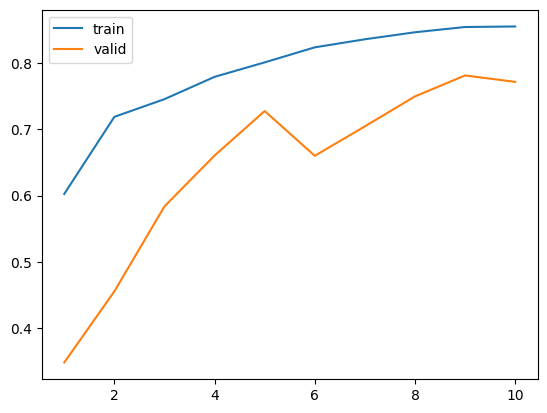

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
epoch_count = range(1, len(hist.history['custom_f1_score']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['custom_f1_score'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_custom_f1_score'], label='valid')
plt.show()

In [39]:
model.evaluate(X_test, y_test)

142/142 [==============================] - 6s 41ms/step - loss: 0.9199 - custom_f1_score: 0.6960


[0.9199353456497192, 0.696013867855072]

### Cambios realizados
* En la columna de rating a los valores 0 y 1 les asigne el valor 0, a los valores 2 y 3 el 1 y a el valor 5 el 2
* Como la distribución de valores estaba desbalanceada realice un Oversampling